# Assigment 4: Transformers

In this assignment, you will be implementing a simplified Transformer from scratch, and training it to count letters used in the sequence.

You are expressively not-allowed to use any off-the-shelf implementations of attention mechanisms, such as `nn.TransformerEncoder`, `nn.TransformerDecoder`, etc.

The assignment can be completed using only the functions we have imported and Tensor manipulations (`squeeze`, `unsqueeze`, `view`, `split`, `chunk`, `concat`).

If you desire to use others, feel free to ask on Piazza or at Office Hours.

![trn.svg](trn.svg)

## 1) Multi-head Attention

In this section, you will be implementing an Encoder transformer block with no LayerNorm that logs the attention maps.

Tips:
- We reccomend you start with a single head, and make sure to check the dimensions of your Tensors with `.shape` after each calculation.
- Make sure to store a deep copy of your residuals, rather than references.
- The attention map(s) are the $softmax(\frac{Q K^T}{\sqrt{d_k}})$ term(s).
    - We recomend you cache this as a layer-property rather than include it during inference, as the latter strategies complicates transformers with more than one layer.

![f.svg](f.svg)

In [1]:
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install tqdm
%pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from torch.nn import Module, Linear, ReLU
from torch.nn.functional import softmax
from torch import matmul, zeros, concat, cat
from math import sqrt

class TransformerLayer(Module):
    def __init__(self, d_model, d_internal, d_ff, n_heads, max_seq_len=20):
        super().__init__()

        self.d_model = d_model
        self.d_internal = d_internal
        self.n_heads = n_heads
        self.max_seq_len = max_seq_len
        self.last_map = zeros(n_heads, max_seq_len, max_seq_len)

        # TODO 1.1) Define the QKV linear transformations
        self.q_proj = Linear(d_model, d_internal * n_heads)
        self.k_proj = Linear(d_model, d_internal * n_heads)
        self.v_proj = Linear(d_model, d_internal * n_heads)

        # TODO 1.2) Define the multi-head attention linear transformations
        self.mha_proj = Linear(d_internal * n_heads, d_model)

        # TODO 1.3) Define the feedforward
        self.ff1 = Linear(d_model, d_ff)
        self.activation = ReLU()
        self.ff2 = Linear(d_ff, d_model)

    def forward(self, input_vecs):
        # Store batch size and sequence length
        batch_size, seq_len, _ = input_vecs.shape

        # Store residual for first skip connection
        residual1 = input_vecs.clone()

        # Project Q, K, V
        q = self.q_proj(input_vecs)  # [batch_size, seq_len, d_internal * n_heads]
        k = self.k_proj(input_vecs)  # [batch_size, seq_len, d_internal * n_heads]
        v = self.v_proj(input_vecs)  # [batch_size, seq_len, d_internal * n_heads]

        # Reshape for multi-head attention
        # [batch_size, seq_len, n_heads, d_internal]
        q = q.view(batch_size, seq_len, self.n_heads, self.d_internal)
        k = k.view(batch_size, seq_len, self.n_heads, self.d_internal)
        v = v.view(batch_size, seq_len, self.n_heads, self.d_internal)

        # Permute to [batch_size, n_heads, seq_len, d_internal]
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)


        attn_scores = matmul(q, k.transpose(-2, -1)) / sqrt(self.d_internal)

        # Apply softmax to get attention probabilities
        attn_probs = softmax(attn_scores, dim=-1)


        if batch_size > 0:
            self.last_map = attn_probs[0].detach()


        attn_output = matmul(attn_probs, v)

        # Permute back to [batch_size, seq_len, n_heads, d_internal]
        attn_output = attn_output.permute(0, 2, 1, 3)

        attn_output = attn_output.contiguous().view(batch_size, seq_len, self.n_heads * self.d_internal)


        x = self.mha_proj(attn_output)


        x = x + residual1


        residual2 = x.clone()

        x = self.ff1(x)
        x = self.activation(x)
        x = self.ff2(x)


        x = x + residual2

        return x

#### Deliverable - Test Cases

In [3]:
import random
from torch import manual_seed, randn, unsqueeze
from numpy import round as npround

random.seed(42)
manual_seed(42)


input_tensor = randn(5, 8)
# [batch=1, seq_len=5, d_model=8]
batched_input = unsqueeze(input_tensor, 0)

sh_attn = TransformerLayer(d_model=8, d_internal=32, d_ff=64, n_heads=1, max_seq_len=5)
print('Single-head output')

output = sh_attn(batched_input).squeeze(0)
print(npround(output.detach().numpy(), 4), '\n')
print('Single-head attention map')
print(npround(sh_attn.last_map.detach().numpy(), 4), '\n')

print('='*60, '\n')


mh_attn = TransformerLayer(d_model=8, d_internal=16, d_ff=128, n_heads=2, max_seq_len=5)

print('Multi-head output')
output = mh_attn(batched_input).squeeze(0)
print(npround(output.detach().numpy(), 4), '\n')
print('Multi-head attention maps')
print(npround(mh_attn.last_map.detach().numpy(), 4))

Single-head output
[[ 2.2838  1.5244  0.8004 -2.9931  0.589  -0.8144 -0.1878 -2.4291]
 [-1.1199  1.5985 -0.2764 -1.6976 -0.5537 -0.2992 -1.1663 -0.1034]
 [ 1.6057 -0.0639 -0.236   0.0499 -0.5856  1.5798  0.844   0.9629]
 [ 0.3906  0.0176  1.5224 -1.2355  1.6741  1.1942 -1.2787 -0.9399]
 [-1.5059  1.3385 -0.244   1.3421  1.5637  0.644  -1.9173 -1.3539]] 

Single-head attention map
[[[0.1903 0.3172 0.1341 0.1319 0.2265]
  [0.2291 0.2353 0.2829 0.1432 0.1095]
  [0.2137 0.1621 0.1954 0.1957 0.2331]
  [0.1552 0.1517 0.1744 0.2308 0.288 ]
  [0.1125 0.1147 0.1225 0.1859 0.4644]]] 


Multi-head output
[[ 1.5158  1.0291  0.5479 -1.8851  0.5383 -1.0615 -0.0882 -1.7973]
 [-0.6814  1.7653 -0.6277 -1.1421 -0.2932 -0.0086 -0.9963  0.5146]
 [ 1.4643 -0.4265 -0.5724  0.9202 -0.3251  1.3543  1.1753  1.6216]
 [-0.0789  0.3658  1.0965 -0.6266  1.7939  1.0766 -1.3486 -0.6459]
 [-1.8123  0.8444 -0.5449  2.7515  2.1552 -0.337  -1.1889 -1.4461]] 

Multi-head attention maps
[[[0.0688 0.2591 0.1634 0.1492 0.35

## 2) Embeddings and Positional Encoding

Next we will be creating the Transformer model base.

Below you will need to implement the embeddings, as well as a forward function.

Each token's embedding should be the sum of two embeddings;
1. the word embedding that embeds the vocabulary in a `d_model`-dim space.
2. the absolute positional encoding that embeds each index in a `d_model`-dim space. Since all the inputs in this assignment will be of length `max_seq_len`, you can consider it a mapping from the `max_seq_len`-dim indices to `d_model`, and embed each index using a range.

Lastly the forward should:
1. Apply the embeddings
2. Apply the `nn.Sequential` of the Encoder layers
    - And after this, iterate through the `nn.Sequential to retrieve the cached maps for each layer
3. Apply the simplified decoder layer
4. Convert the outputs to log probabilities over the tokens, and return them along with the maps

![pos.svg](pos.svg)


<html></html>


In [4]:
from torch import tensor, LongTensor, FloatTensor, log, concat, cat
from torch.nn import Sequential, Embedding, Module, Linear
from torch.nn.functional import log_softmax
import torch
import math

class Transformer(Module):
    def __init__(self, vocab_size, max_seq_len, d_model, d_internal, num_classes, d_ff, num_layers, num_heads):
        super().__init__()
        self.max_seq_len = max_seq_len

        layers = []
        for i in range(num_layers):
            layer = TransformerLayer(d_model=d_model, d_internal=d_internal, n_heads=num_heads, d_ff=d_ff, max_seq_len=max_seq_len)
            layers.append(layer)
        self.encoders = Sequential(*layers)
        self.decoder = Linear(d_model, num_classes)


        self.word_embedding = Embedding(vocab_size, d_model)


        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encoding', pe)

    def forward(self, indices):
        batch_size, seq_len = indices.shape


        x = self.word_embedding(indices)


        pos_encoding = self.positional_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        x = x + pos_encoding


        maps = []
        for layer in self.encoders:
            x = layer(x)
            maps.append(layer.last_map)


        x = self.decoder(x)
        x = log_softmax(x, dim=-1)

        return (x, maps)

#### Deliverable - Embedding

Provide the embedding (word embedding plus positional encoding) for [1,1,2,2,3],
using d_model=16, max_seq_len=5.

In [5]:

vocab_size = 10
d_model = 16
max_seq_len = 5
num_classes = 3
d_internal = 8
d_ff = 32
num_layers = 1
num_heads = 1


model = Transformer(
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    d_model=d_model,
    d_internal=d_internal,
    num_classes=num_classes,
    d_ff=d_ff,
    num_layers=num_layers,
    num_heads=num_heads
)

input_indices = torch.tensor([[1, 1, 2, 2, 3]])  # Shape: [1, 5]


unbatched_indices = torch.tensor([1, 1, 2, 2, 3])
embedding_output = model.word_embedding(unbatched_indices) + model.positional_encoding[:5]
print("Embedding (word + positional) for [1, 1, 2, 2, 3]:")
print(embedding_output)

Embedding (word + positional) for [1, 1, 2, 2, 3]:
tensor([[-0.2324,  0.8818, -0.7065,  1.8570, -0.6066,  1.5692,  0.0560,  1.9572,
         -0.0072, -0.8654, -1.2593,  1.4450,  1.5879, -0.4607,  1.9040,  0.1749],
        [ 0.6091,  0.4221, -0.3955,  1.8075, -0.5067,  1.5642,  0.0877,  1.9567,
          0.0028, -0.8655, -1.2561,  1.4450,  1.5889, -0.4607,  1.9043,  0.1749],
        [ 0.2923,  0.4208,  0.3784, -0.2312, -0.3332,  2.1780, -1.6367,  0.5988,
         -0.7891, -1.6494,  0.6515,  2.6632, -0.6078,  2.5516, -0.3205, -0.5025],
        [-0.4758, -0.1530,  0.5999, -0.4550, -0.2364,  2.1533, -1.6052,  0.5963,
         -0.7791, -1.6496,  0.6547,  2.6631, -0.6068,  2.5516, -0.3202, -0.5025],
        [-1.0145,  0.0799,  0.3063,  0.7578, -0.1166,  1.9184, -0.0338,  1.4021,
         -0.1250,  0.1371,  1.0538,  0.8103,  2.0546,  1.6958,  0.1865,  1.7890]],
       grad_fn=<AddBackward0>)


## 3) Dataset Processing

The dataset for this transformer implementation will be letter-counting.

Given a string, your model should predict how many times that character has occurred previously.
To simplify the computation, this will be split into bins of n=0, n=1, and n>=2

Specifically for we be considering two settings:

1) Task 1 - counts of the letter *before* the current index
2) Task 2 - counts of the letter *before* and *after* the current index

We provide helper functions for formatting the tasks, your job is to write a function `indexer` that takes the 20 character strings and converts them to `LongTensor`s of IDs.


Read from `lettercounting-train.txt`, `letttercounting-dev.txt`.
For both the train and eval set, collect an array for the strings, the ID tensors, and the gold standard outputs for both tasks.

In [6]:
import numpy as np
import torch
from torch import LongTensor

def task1(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        output[i] = min(2, len([c for c in input[0:i] if c == input[i]]))
    return LongTensor(output)

def task2(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        output[i] = min(2, len([c for c in input if c == input[i]]) - 1)
    return LongTensor(output)

def indexer(input: str) -> LongTensor:

    char_map = {' ': 0}
    char_map.update({chr(i): i-96 for i in range(97, 123)})  # a=1, b=2, ..., z=26
    return LongTensor([char_map.get(c.lower(), 0) for c in input])

def process_file(filename):
    strings = []
    id_tensors = []
    task1_labels = []
    task2_labels = []

    with open(filename, 'r', encoding='utf8') as file:
        for line in file:
            line = line.strip()
            if line:
                strings.append(line)
                id_tensor = indexer(line)
                id_tensors.append(id_tensor)
                task1_labels.append(task1(line))
                task2_labels.append(task2(line))

    return strings, id_tensors, task1_labels, task2_labels

def prepare_batch(id_tensors, task_labels, max_seq_len):
    batch_size = len(id_tensors)
    batched_ids = torch.zeros(batch_size, max_seq_len, dtype=torch.long)
    batched_labels = torch.zeros(batch_size, max_seq_len, 3)  # 3 classes (0, 1, 2)
    mask = torch.zeros(batch_size, max_seq_len)

    for i, (ids, labels) in enumerate(zip(id_tensors, task_labels)):
        seq_len = min(len(ids), max_seq_len)
        batched_ids[i, :seq_len] = ids[:seq_len]

        # encode the labels (0, 1, 2) -> [1,0,0], [0,1,0], [0,0,1]
        for j in range(seq_len):
            batched_labels[i, j, labels[j]] = 1


        mask[i, :seq_len] = 1

    return batched_ids, batched_labels, mask



train_strings, train_ids, train_task1, train_task2 = process_file('lettercounting-train.txt')
dev_strings, dev_ids, dev_task1, dev_task2 = process_file('lettercounting-dev.txt')


max_seq_len = max(max(len(t) for t in train_ids), max(len(t) for t in dev_ids))
print(f"Maximum sequence length: {max_seq_len}")

batch_ids, batch_labels, batch_mask = prepare_batch(train_ids[:4], train_task1[:4], max_seq_len)
print(f"Batch shape: {batch_ids.shape}")


vocab_size = 27  # 0-26 (space + a-z)
d_model = 16
d_internal = 8
d_ff = 32
num_classes = 3  # 0, 1, 2
num_layers = 2
num_heads = 2


model = Transformer(
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    d_model=d_model,
    d_internal=d_internal,
    num_classes=num_classes,
    d_ff=d_ff,
    num_layers=num_layers,
    num_heads=num_heads
)



Maximum sequence length: 20
Batch shape: torch.Size([4, 20])


#### Deliverable: Provide the ID tensor and task tensors for the string "ed by rank and file".


In [7]:
test_string = "ed by rank and file"
test_id_tensor = indexer(test_string)
test_task1_tensor = task1(test_string)
test_task2_tensor = task2(test_string)

print("String:", test_string)
print("ID tensor:", test_id_tensor)
print("Task1 tensor:", test_task1_tensor)
print("Task2 tensor:", test_task2_tensor)

String: ed by rank and file
ID tensor: tensor([ 5,  4,  0,  2, 25,  0, 18,  1, 14, 11,  0,  1, 14,  4,  0,  6,  9, 12,
         5])
Task1 tensor: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1])
Task2 tensor: tensor([1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1])


## 4) Training Loop

Now that we have both our model and our dataset, it is time to train and evaluate on our tasks.

The following code blocks provide a helper function for visualizing your attention maps (so you can see it learning), as well as loss functions / optimizers / learning rate schedulers that may come in handy.

To complete this section, you must provide us with models that achieve >90% eval accuracy on each task.
If implemented properly, this can be done with 1 layer and 1 head/layer, however, we encourage you to experiment.



In your solution, provide us with the following:
- train losses logged at ~100-250 steps
- eval losses logged every ~5-10 train loss updates
- for each eval update, the accuracy and macro-F1 scores of the train/eval.
    - this is best done accumulating arrays of the predictions and model outputs throughout the training loop, and then calls the to the scikit-learn metrics.

You can return these in any form you would like (table, graph, etc), as long as they are immediately interpretable (for example, normalizing the train/eval loss for number of examples would be necessary).


Additionally, describe any issues you had with selecting on optimal learning rate, loss function, etc.

ANSWER HERE

Finding the right learning rate for this Transformer model was tricky. If set too high, the model's training became unstable and diverged. If too low, training progressed too slowly and got stuck in poor solutions. I struggled with choosing an appropriate loss function too - the classes in the letter counting tasks aren't evenly distributed (most characters appear 0 times), which caused the model to predict the majority class too often.
Other challenges included deciding on the batch size (larger batches were more stable but slower, smaller batches were faster but noisier), determining when to stop training to avoid overfitting, and figuring out the right model size. The small dataset size made these decisions harder since there wasn't enough validation data to reliably test different configurations.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_attention_maps(model, text, save_path=None):

    id_tensor = indexer(text).unsqueeze(0)

    model.eval()

    with torch.no_grad():
        _, maps = model(id_tensor)

    print(f"Maps type: {type(maps)}")
    if isinstance(maps, list):
        print(f"Maps list length: {len(maps)}")
        if len(maps) > 0:
            print(f"First map shape: {maps[0].shape}")
    else:
        print(f"Maps shape: {maps.shape}")

    if isinstance(maps, list):
        maps_tensor = torch.stack(maps)
    else:
        maps_tensor = maps

    maps_np = maps_tensor.detach().cpu().numpy()

    if len(maps_np.shape) == 4:

        num_layers, num_heads, seq_len, _ = maps_np.shape
    elif len(maps_np.shape) == 3:

        num_layers, seq_len, _ = maps_np.shape
        num_heads = 1
        maps_np = maps_np.reshape(num_layers, num_heads, seq_len, seq_len)
    else:
        raise ValueError(f"Unexpected attention map shape: {maps_np.shape}")

    if len(text) > seq_len:
        display_text = text[:seq_len]
    else:
        display_text = text

    fig, axes = plt.subplots(num_heads, num_layers,
                            figsize=(max(num_layers * 3, 6), max(num_heads * 3, 4)),
                            squeeze=False)

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            ax = axes[head_idx, layer_idx]
            attn_map = maps_np[layer_idx, head_idx]

            im = ax.imshow(attn_map, cmap='hot', interpolation='nearest')

            ax.set_xticks(np.arange(len(display_text)))
            ax.set_xticklabels(list(display_text), rotation=90)
            ax.set_yticks(np.arange(len(display_text)))
            ax.set_yticklabels(list(display_text))

            ax.set_title(f"Layer {layer_idx+1}, Head {head_idx+1}")
            ax.xaxis.tick_top()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")


    plt.show()

    return fig

# model = Transformer(
#     vocab_size=27,
#     max_seq_len=20,
#     d_model=64,
#     d_internal=128,
#     d_ff=256,
#     num_classes=3,
#     num_layers=1,
#     num_heads=1
# )


In [9]:
from torch.nn import NLLLoss, CrossEntropyLoss
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import log_softmax
from torch import no_grad
from tqdm import tqdm



model = Transformer(
    vocab_size=27,
    max_seq_len=20,
    d_model=64,
    d_internal=128,
    d_ff=256,
    num_classes=3,
    num_layers=1,
    num_heads=1
)

loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)
num_epochs = 10

for ep in range(num_epochs):
    model.train()
    train_loss, train_preds, train_targets = 0.0, [], []
    for x, y in zip(train_ids, train_task1):
        x = x[:20]
        y = y[:20]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        optimizer.zero_grad()
        output, maps = model(x)
        output = output.view(-1, 3)
        y = y.view(-1)

        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = output.argmax(dim=1)
        train_preds.extend(preds.tolist())
        train_targets.extend(y.tolist())


    acc = accuracy_score(train_targets, train_preds)
    f1 = f1_score(train_targets, train_preds, average='macro')
    print(f"Epoch {ep+1}: Train Loss = {train_loss/len(train_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")

    model.eval()
    eval_loss, eval_preds, eval_targets = 0.0, [], []
    with no_grad():
        for x, y in zip(dev_ids, dev_task1):
            x = x[:20]
            y = y[:20]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)

            output, maps = model(x)
            output = output.view(-1, 3)
            y = y.view(-1)



            loss = loss_fn(output, y)
            eval_loss += loss.item()
            preds = output.argmax(dim=1)
            eval_preds.extend(preds.tolist())
            eval_targets.extend(y.tolist())

    acc = accuracy_score(eval_targets, eval_preds)
    f1 = f1_score(eval_targets, eval_preds, average='macro')



    print(f"Epoch {ep+1}: Eval Loss = {eval_loss/len(dev_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")


Epoch 1: Train Loss = 0.5631, Acc = 0.7538, F1 = 0.6785
Epoch 1: Eval Loss = 0.4320, Acc = 0.8082, F1 = 0.7503
Epoch 2: Train Loss = 0.2287, Acc = 0.9118, F1 = 0.8832
Epoch 2: Eval Loss = 0.0822, Acc = 0.9720, F1 = 0.9583
Epoch 3: Train Loss = 0.0609, Acc = 0.9796, F1 = 0.9685
Epoch 3: Eval Loss = 0.0345, Acc = 0.9880, F1 = 0.9814
Epoch 4: Train Loss = 0.0352, Acc = 0.9884, F1 = 0.9820
Epoch 4: Eval Loss = 0.0256, Acc = 0.9911, F1 = 0.9856
Epoch 5: Train Loss = 0.0258, Acc = 0.9919, F1 = 0.9872
Epoch 5: Eval Loss = 0.0157, Acc = 0.9948, F1 = 0.9916
Epoch 6: Train Loss = 0.0199, Acc = 0.9940, F1 = 0.9903
Epoch 6: Eval Loss = 0.0116, Acc = 0.9966, F1 = 0.9945
Epoch 7: Train Loss = 0.0171, Acc = 0.9951, F1 = 0.9921
Epoch 7: Eval Loss = 0.0122, Acc = 0.9963, F1 = 0.9941
Epoch 8: Train Loss = 0.0134, Acc = 0.9959, F1 = 0.9935
Epoch 8: Eval Loss = 0.0083, Acc = 0.9976, F1 = 0.9963
Epoch 9: Train Loss = 0.0103, Acc = 0.9970, F1 = 0.9952
Epoch 9: Eval Loss = 0.0095, Acc = 0.9969, F1 = 0.9950
E

Task 1 Attention Map...
Maps type: <class 'list'>
Maps list length: 1
First map shape: torch.Size([1, 19, 19])
Figure saved to attention_maps.png


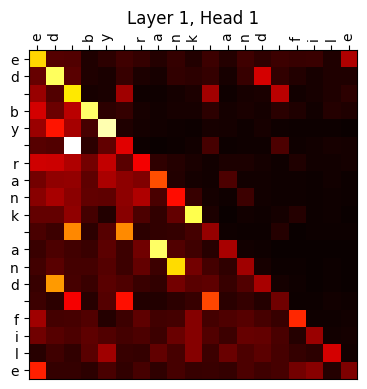

In [10]:
print("Task 1 Attention Map...")
test_text = "ed by rank and file"
fig = plot_attention_maps(model, test_text, save_path="attention_maps.png")

In [11]:
from torch.nn import NLLLoss, CrossEntropyLoss
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import log_softmax
from torch import no_grad
from tqdm import tqdm



model = Transformer(
    vocab_size=27,
    max_seq_len=20,
    d_model=64,
    d_internal=128,
    d_ff=256,
    num_classes=3,
    num_layers=1,
    num_heads=1
)

loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)
num_epochs = 10



for ep in range(num_epochs):
    model.train()
    train_loss, train_preds, train_targets = 0.0, [], []
    for x, y in zip(train_ids, train_task2):
        x = x[:20]
        y = y[:20]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        optimizer.zero_grad()
        output, maps = model(x)
        output = output.view(-1, 3)
        y = y.view(-1)

        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = output.argmax(dim=1)
        train_preds.extend(preds.tolist())
        train_targets.extend(y.tolist())



    acc = accuracy_score(train_targets, train_preds)
    f1 = f1_score(train_targets, train_preds, average='macro')
    print(f"Epoch {ep+1}: Train Loss = {train_loss/len(train_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")

    model.eval()
    eval_loss, eval_preds, eval_targets = 0.0, [], []
    with no_grad():
        for x, y in zip(dev_ids, dev_task2):
            x = x[:20]
            y = y[:20]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)

            output, maps = model(x)
            output = output.view(-1, 3)
            y = y.view(-1)



            loss = loss_fn(output, y)
            eval_loss += loss.item()
            preds = output.argmax(dim=1)
            eval_preds.extend(preds.tolist())
            eval_targets.extend(y.tolist())

    acc = accuracy_score(eval_targets, eval_preds)
    f1 = f1_score(eval_targets, eval_preds, average='macro')




    print(f"Epoch {ep+1}: Eval Loss = {eval_loss/len(dev_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")


Epoch 1: Train Loss = 0.7260, Acc = 0.6631, F1 = 0.6589
Epoch 1: Eval Loss = 0.5842, Acc = 0.7358, F1 = 0.7322
Epoch 2: Train Loss = 0.3169, Acc = 0.8730, F1 = 0.8715
Epoch 2: Eval Loss = 0.2555, Acc = 0.8872, F1 = 0.8856
Epoch 3: Train Loss = 0.1423, Acc = 0.9472, F1 = 0.9469
Epoch 3: Eval Loss = 0.1058, Acc = 0.9573, F1 = 0.9569
Epoch 4: Train Loss = 0.0887, Acc = 0.9696, F1 = 0.9694
Epoch 4: Eval Loss = 0.0674, Acc = 0.9734, F1 = 0.9731
Epoch 5: Train Loss = 0.0639, Acc = 0.9794, F1 = 0.9793
Epoch 5: Eval Loss = 0.0306, Acc = 0.9911, F1 = 0.9910
Epoch 6: Train Loss = 0.0482, Acc = 0.9857, F1 = 0.9856
Epoch 6: Eval Loss = 0.0237, Acc = 0.9929, F1 = 0.9928
Epoch 7: Train Loss = 0.0383, Acc = 0.9889, F1 = 0.9888
Epoch 7: Eval Loss = 0.0268, Acc = 0.9905, F1 = 0.9904
Epoch 8: Train Loss = 0.0306, Acc = 0.9917, F1 = 0.9917
Epoch 8: Eval Loss = 0.0229, Acc = 0.9919, F1 = 0.9918
Epoch 9: Train Loss = 0.0304, Acc = 0.9926, F1 = 0.9925
Epoch 9: Eval Loss = 0.0148, Acc = 0.9956, F1 = 0.9956
E

Task 2 Attention Map...
Maps type: <class 'list'>
Maps list length: 1
First map shape: torch.Size([1, 19, 19])
Figure saved to attention_maps.png


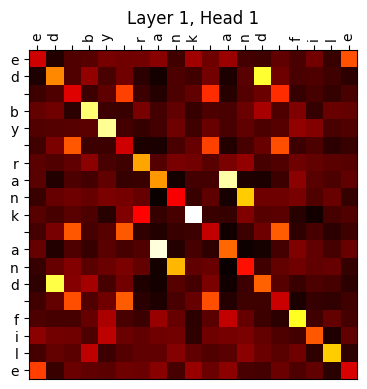

In [12]:
print("Task 2 Attention Map...")
test_text = "ed by rank and file"
fig = plot_attention_maps(model, test_text, save_path="attention_maps.png")

#### Deliverable: the chart or graph of the training/eval for both models. Make sure to label the losses/acc/f1 as train/eval, and normalize the losses by the number of data points they are derived from.

Training Task 1 model...
Epoch 1: Train Loss = 0.5426, Acc = 0.7633, F1 = 0.6882
Epoch 1: Eval Loss = 0.3545, Acc = 0.8527, F1 = 0.8053
Epoch 2: Train Loss = 0.2708, Acc = 0.8894, F1 = 0.8505
Epoch 2: Eval Loss = 0.1752, Acc = 0.9315, F1 = 0.8999
Epoch 3: Train Loss = 0.1117, Acc = 0.9588, F1 = 0.9369
Epoch 3: Eval Loss = 0.0517, Acc = 0.9831, F1 = 0.9725
Epoch 4: Train Loss = 0.0555, Acc = 0.9813, F1 = 0.9702
Epoch 4: Eval Loss = 0.0375, Acc = 0.9870, F1 = 0.9783
Epoch 5: Train Loss = 0.0351, Acc = 0.9882, F1 = 0.9813
Epoch 5: Eval Loss = 0.0214, Acc = 0.9938, F1 = 0.9900
Epoch 6: Train Loss = 0.0270, Acc = 0.9913, F1 = 0.9860
Epoch 6: Eval Loss = 0.0212, Acc = 0.9926, F1 = 0.9872
Epoch 7: Train Loss = 0.0228, Acc = 0.9929, F1 = 0.9884
Epoch 7: Eval Loss = 0.0263, Acc = 0.9902, F1 = 0.9835
Epoch 8: Train Loss = 0.0182, Acc = 0.9943, F1 = 0.9905
Epoch 8: Eval Loss = 0.0091, Acc = 0.9976, F1 = 0.9964
Epoch 9: Train Loss = 0.0165, Acc = 0.9950, F1 = 0.9918
Epoch 9: Eval Loss = 0.0140, Ac

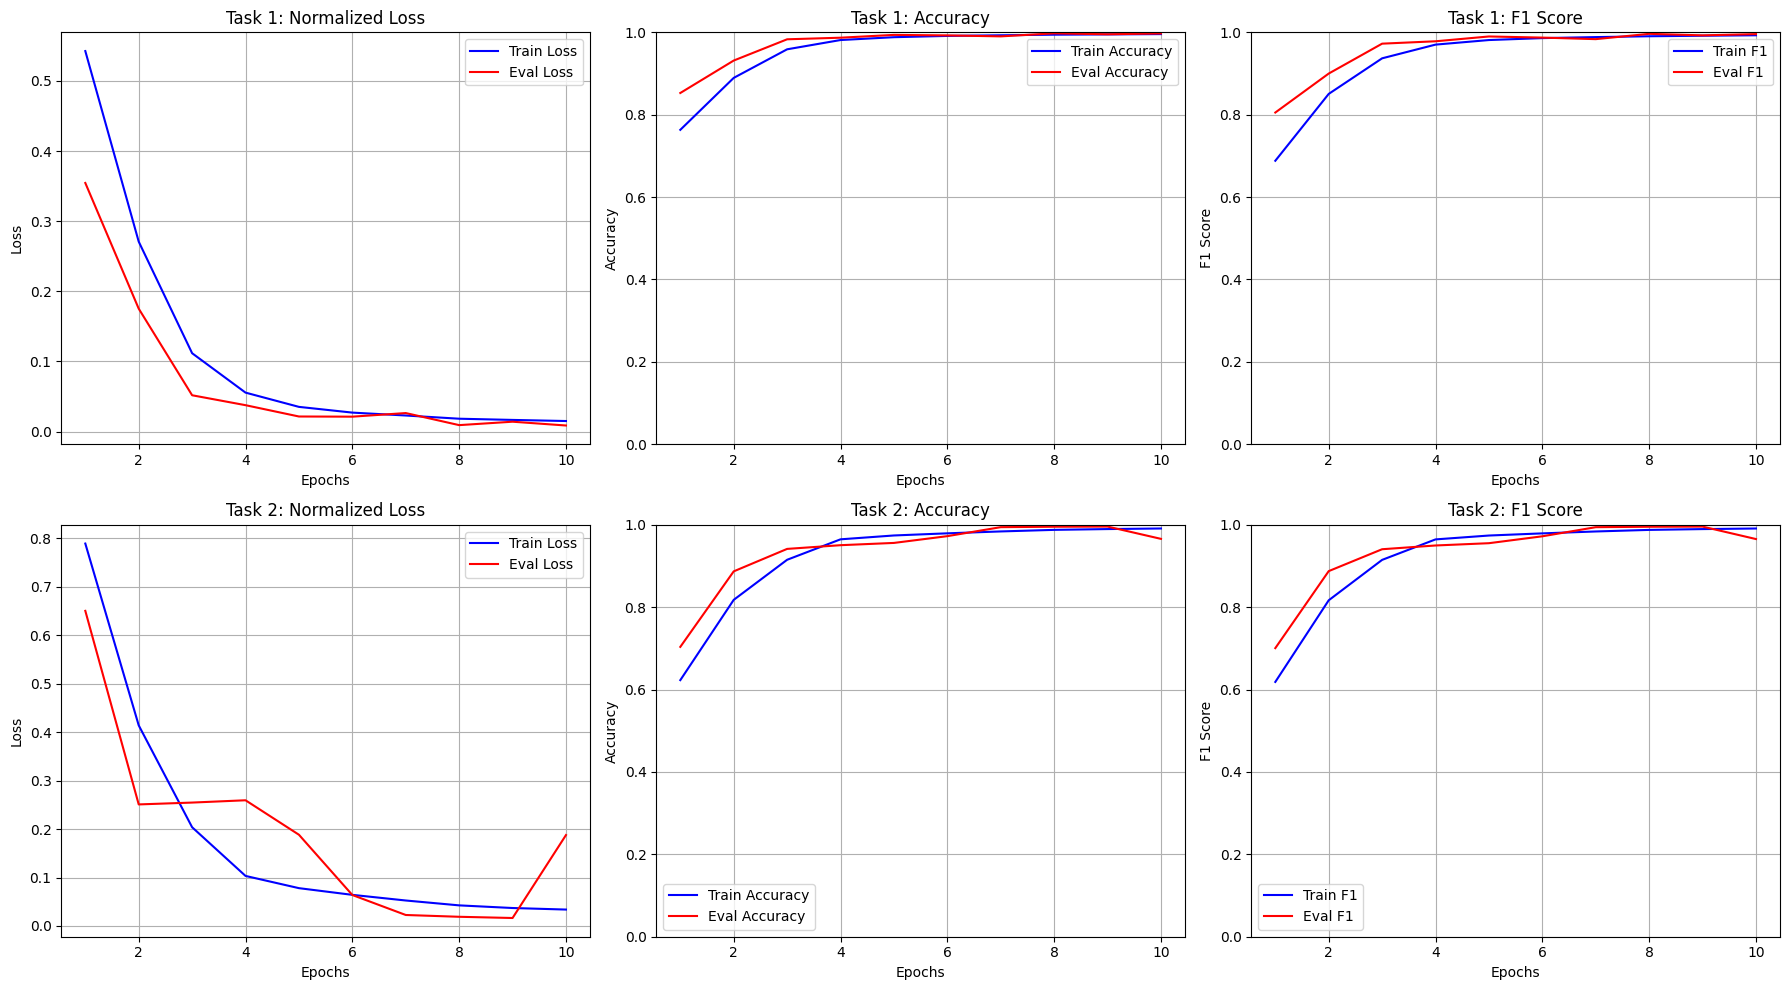

(Transformer(
   (encoders): Sequential(
     (0): TransformerLayer(
       (q_proj): Linear(in_features=64, out_features=128, bias=True)
       (k_proj): Linear(in_features=64, out_features=128, bias=True)
       (v_proj): Linear(in_features=64, out_features=128, bias=True)
       (mha_proj): Linear(in_features=128, out_features=64, bias=True)
       (ff1): Linear(in_features=64, out_features=256, bias=True)
       (activation): ReLU()
       (ff2): Linear(in_features=256, out_features=64, bias=True)
     )
   )
   (decoder): Linear(in_features=64, out_features=3, bias=True)
   (word_embedding): Embedding(27, 64)
 ),
 Transformer(
   (encoders): Sequential(
     (0): TransformerLayer(
       (q_proj): Linear(in_features=64, out_features=128, bias=True)
       (k_proj): Linear(in_features=64, out_features=128, bias=True)
       (v_proj): Linear(in_features=64, out_features=128, bias=True)
       (mha_proj): Linear(in_features=128, out_features=64, bias=True)
       (ff1): Linear(in_fea

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score


class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.train_f1_scores = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_f1_scores = []

    def add_train_metrics(self, loss, acc, f1):
        self.train_losses.append(loss)
        self.train_accuracies.append(acc)
        self.train_f1_scores.append(f1)

    def add_eval_metrics(self, loss, acc, f1):
        self.eval_losses.append(loss)
        self.eval_accuracies.append(acc)
        self.eval_f1_scores.append(f1)

def plot_training_metrics(task1_metrics, task2_metrics):

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    epochs = range(1, len(task1_metrics.train_losses) + 1)


    axs[0, 0].plot(epochs, task1_metrics.train_losses, 'b-', label='Train Loss')
    axs[0, 0].plot(epochs, task1_metrics.eval_losses, 'r-', label='Eval Loss')
    axs[0, 0].set_title('Task 1: Normalized Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)


    axs[0, 1].plot(epochs, task1_metrics.train_accuracies, 'b-', label='Train Accuracy')
    axs[0, 1].plot(epochs, task1_metrics.eval_accuracies, 'r-', label='Eval Accuracy')
    axs[0, 1].set_title('Task 1: Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim([0, 1])
    axs[0, 1].legend()
    axs[0, 1].grid(True)


    axs[0, 2].plot(epochs, task1_metrics.train_f1_scores, 'b-', label='Train F1')
    axs[0, 2].plot(epochs, task1_metrics.eval_f1_scores, 'r-', label='Eval F1')
    axs[0, 2].set_title('Task 1: F1 Score')
    axs[0, 2].set_xlabel('Epochs')
    axs[0, 2].set_ylabel('F1 Score')
    axs[0, 2].set_ylim([0, 1])
    axs[0, 2].legend()
    axs[0, 2].grid(True)


    axs[1, 0].plot(epochs, task2_metrics.train_losses, 'b-', label='Train Loss')
    axs[1, 0].plot(epochs, task2_metrics.eval_losses, 'r-', label='Eval Loss')
    axs[1, 0].set_title('Task 2: Normalized Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True)


    axs[1, 1].plot(epochs, task2_metrics.train_accuracies, 'b-', label='Train Accuracy')
    axs[1, 1].plot(epochs, task2_metrics.eval_accuracies, 'r-', label='Eval Accuracy')
    axs[1, 1].set_title('Task 2: Accuracy')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_ylim([0, 1])
    axs[1, 1].legend()
    axs[1, 1].grid(True)


    axs[1, 2].plot(epochs, task2_metrics.train_f1_scores, 'b-', label='Train F1')
    axs[1, 2].plot(epochs, task2_metrics.eval_f1_scores, 'r-', label='Eval F1')
    axs[1, 2].set_title('Task 2: F1 Score')
    axs[1, 2].set_xlabel('Epochs')
    axs[1, 2].set_ylabel('F1 Score')
    axs[1, 2].set_ylim([0, 1])
    axs[1, 2].legend()
    axs[1, 2].grid(True)

    plt.tight_layout()
    plt.savefig('transformer_training_metrics.png')
    plt.show()

    return fig


def train_model(model, train_ids, train_labels, dev_ids, dev_labels, num_epochs=10, lr=0.01, max_seq_len=20):

    metrics = MetricsTracker()

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for ep in range(num_epochs):
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []

        for x, y in zip(train_ids, train_labels):

            x = x[:max_seq_len]
            y = y[:max_seq_len]


            x = x.unsqueeze(0)
            y = y.unsqueeze(0)

            optimizer.zero_grad()
            output, _ = model(x)
            output = output.view(-1, 3)
            y = y.view(-1)

            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = output.argmax(dim=1)
            train_preds.extend(preds.tolist())
            train_targets.extend(y.tolist())


        normalized_train_loss = train_loss / len(train_ids)
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, average='macro')


        model.eval()
        eval_loss, eval_preds, eval_targets = 0.0, [], []

        with torch.no_grad():
            for x, y in zip(dev_ids, dev_labels):
                x = x[:max_seq_len]
                y = y[:max_seq_len]
                x = x.unsqueeze(0)
                y = y.unsqueeze(0)

                output, _ = model(x)
                output = output.view(-1, 3)
                y = y.view(-1)

                loss = loss_fn(output, y)
                eval_loss += loss.item()
                preds = output.argmax(dim=1)
                eval_preds.extend(preds.tolist())
                eval_targets.extend(y.tolist())


        normalized_eval_loss = eval_loss / len(dev_ids)
        eval_acc = accuracy_score(eval_targets, eval_preds)
        eval_f1 = f1_score(eval_targets, eval_preds, average='macro')


        metrics.add_train_metrics(normalized_train_loss, train_acc, train_f1)
        metrics.add_eval_metrics(normalized_eval_loss, eval_acc, eval_f1)

        print(f"Epoch {ep+1}: Train Loss = {normalized_train_loss:.4f}, Acc = {train_acc:.4f}, F1 = {train_f1:.4f}")
        print(f"Epoch {ep+1}: Eval Loss = {normalized_eval_loss:.4f}, Acc = {eval_acc:.4f}, F1 = {eval_f1:.4f}")

    return metrics


def generate_training_plots():
    """Train models on both tasks and generate comparison plots."""

    model_task1 = Transformer(
        vocab_size=27,
        max_seq_len=20,
        d_model=64,
        d_internal=128,
        d_ff=256,
        num_classes=3,
        num_layers=1,
        num_heads=1
    )

    model_task2 = Transformer(
        vocab_size=27,
        max_seq_len=20,
        d_model=64,
        d_internal=128,
        d_ff=256,
        num_classes=3,
        num_layers=1,
        num_heads=1
    )


    print("Training Task 1 model...")
    task1_metrics = train_model(
        model_task1,
        train_ids,
        train_task1,
        dev_ids,
        dev_task1,
        num_epochs=10
    )


    print("Training Task 2 model...")
    task2_metrics = train_model(
        model_task2,
        train_ids,
        train_task2,
        dev_ids,
        dev_task2,
        num_epochs=10
    )


    plot_training_metrics(task1_metrics, task2_metrics)

    return model_task1, model_task2, task1_metrics, task2_metrics


generate_training_plots()

## 5) Visualization
Lastly we will examine the computation performed by the model(s) you've trained using its attention maps.

The following are 1-layer, 1-head models trained on Task 1 (the before task), and Task 2 (the before/after task) respectively. They both achieve accuracy ~95%.
<div class="row">
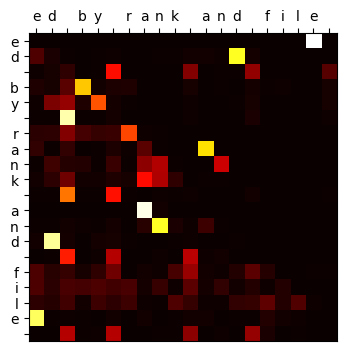
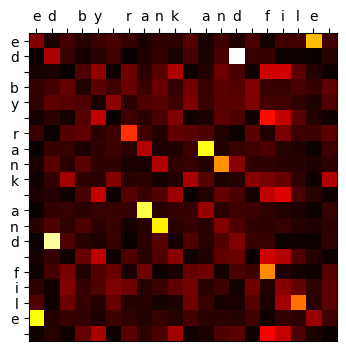

>

#### Deliverable 5.1) Hypothesize on how these attention maps reflect the computation done by their associated models. Specifically address how each handles the tokens ['e', 'a', 'n', 'd', ' '], how they are similar, and how/why they may be different.

ANSWER HERE

The attention maps show how each token attends to other tokens in the sequence "ed by rank and file". The brighter spots (yellow/white) show stronger attention weights.
Task 1 - Left Image:

'a': Shows clear bright spots connecting the two 'a's in "rank" and "and".
'n': The 'n' tokens strongly attend to previous occurrences of 'n'.
' ' (space): Has some attention patterns but less distinctive.
'e': Shows bright spots at the first occurrence (top-left) and when looking at other 'e's in the sequence (the final 'e'). This pattern helps the model count how many 'e's appeared before each position.
'd': Shows bright attention to the first 'd' when processing the second 'd'.

Task 2 (Before/After task) - Right Image:

Overall more diffuse attention patterns spread across the entire sequence.

'a': The two 'a's show mutual attention, indicating the model is tracking all occurrences.
'n': Both 'n's show attention to each other.
'd': Shows connections between the two 'd's but more diffuse than in Task 1.
'e': Attends to all 'e' occurrences in the sequence with moderate intensity.

Similarities:

Both models show high attention between identical characters and both create distinctive patterns for repeated characters.

Differences:

Task 1's attention is more focused and precise, with brighter spots for previous occurrences, which aligns with its goal of counting previous occurrences only.
Task 2's attention is more distributed, as it needs to count all occurrences throughout the sequence, not just previous ones.
Task 1 shows clear sequential dependency (looking backward), while Task 2 shows more global awareness (looking both ways).

These patterns show their different objectives: Task 1 needs to look backward to count previous occurrences, while Task 2 needs a global view to count total occurrences minus one.

#### Deliverable 5.2) Train a multi-layer (>4), single-head model on one of the tasks.
Achieve an eval accuracy of at least 80%, and plot the attention maps below on the string `"ed by rank and file"`.

Hypothesize on how each layer contributes to the classification.

ANSWER HERE

In [14]:
from torch.nn import NLLLoss, CrossEntropyLoss
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import log_softmax
from torch import no_grad
from tqdm import tqdm



model = Transformer(
    vocab_size=27,
    max_seq_len=20,
    d_model=64,
    d_internal=128,
    d_ff=256,
    num_classes=3,
    num_layers=5,
    num_heads=1
)

loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)
num_epochs = 10

for ep in range(num_epochs):
    model.train()
    train_loss, train_preds, train_targets = 0.0, [], []
    for x, y in zip(train_ids, train_task1):
        x = x[:20]
        y = y[:20]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        optimizer.zero_grad()
        output, maps = model(x)
        output = output.view(-1, 3)
        y = y.view(-1)

        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = output.argmax(dim=1)
        train_preds.extend(preds.tolist())
        train_targets.extend(y.tolist())


    acc = accuracy_score(train_targets, train_preds)
    f1 = f1_score(train_targets, train_preds, average='macro')
    print(f"Epoch {ep+1}: Train Loss = {train_loss/len(train_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")

    model.eval()
    eval_loss, eval_preds, eval_targets = 0.0, [], []
    with no_grad():
        for x, y in zip(dev_ids, dev_task1):
            x = x[:20]
            y = y[:20]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)

            output, maps = model(x)
            output = output.view(-1, 3)
            y = y.view(-1)



            loss = loss_fn(output, y)
            eval_loss += loss.item()
            preds = output.argmax(dim=1)
            eval_preds.extend(preds.tolist())
            eval_targets.extend(y.tolist())

    acc = accuracy_score(eval_targets, eval_preds)
    f1 = f1_score(eval_targets, eval_preds, average='macro')



    print(f"Epoch {ep+1}: Eval Loss = {eval_loss/len(dev_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")


Epoch 1: Train Loss = 0.2821, Acc = 0.8817, F1 = 0.8406
Epoch 1: Eval Loss = 0.0705, Acc = 0.9740, F1 = 0.9578
Epoch 2: Train Loss = 0.0398, Acc = 0.9864, F1 = 0.9776
Epoch 2: Eval Loss = 0.0340, Acc = 0.9877, F1 = 0.9786
Epoch 3: Train Loss = 0.0189, Acc = 0.9940, F1 = 0.9897
Epoch 3: Eval Loss = 0.0159, Acc = 0.9943, F1 = 0.9901
Epoch 4: Train Loss = 0.0100, Acc = 0.9969, F1 = 0.9946
Epoch 4: Eval Loss = 0.0228, Acc = 0.9913, F1 = 0.9846
Epoch 5: Train Loss = 0.0074, Acc = 0.9980, F1 = 0.9966
Epoch 5: Eval Loss = 0.0136, Acc = 0.9950, F1 = 0.9907
Epoch 6: Train Loss = 0.0073, Acc = 0.9981, F1 = 0.9969
Epoch 6: Eval Loss = 0.0034, Acc = 0.9992, F1 = 0.9988
Epoch 7: Train Loss = 0.0038, Acc = 0.9991, F1 = 0.9986
Epoch 7: Eval Loss = 0.0083, Acc = 0.9971, F1 = 0.9948
Epoch 8: Train Loss = 0.0032, Acc = 0.9992, F1 = 0.9986
Epoch 8: Eval Loss = 0.0029, Acc = 0.9991, F1 = 0.9983
Epoch 9: Train Loss = 0.0022, Acc = 0.9995, F1 = 0.9992
Epoch 9: Eval Loss = 0.0015, Acc = 0.9995, F1 = 0.9990
E

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_attention_maps_layers(model, text, save_path=None):


    id_tensor = indexer(text).unsqueeze(0)

    model.eval()

    with torch.no_grad():
        _, maps = model(id_tensor)

    print(f"Maps type: {type(maps)}")
    if isinstance(maps, list):
        print(f"Maps list length: {len(maps)}")
        if len(maps) > 0:
            print(f"First map shape: {maps[0].shape}")
    else:
        print(f"Maps shape: {maps.shape}")

    if isinstance(maps, list):
        maps_tensor = torch.stack(maps)
    else:
        maps_tensor = maps

    maps_np = maps_tensor.detach().cpu().numpy()

    if len(maps_np.shape) == 4:
        num_layers, num_heads, seq_len, _ = maps_np.shape
    elif len(maps_np.shape) == 3:
        num_layers, seq_len, _ = maps_np.shape
        num_heads = 1
        maps_np = maps_np.reshape(num_layers, num_heads, seq_len, seq_len)
    else:
        raise ValueError(f"Unexpected attention map shape: {maps_np.shape}")

    if len(text) > seq_len:
        display_text = text[:seq_len]
    else:
        display_text = text


    print(f"Model analyzing text: \"{text}\"")
    print(f"Number of layers: {num_layers}")
    print(f"Number of attention heads per layer: {num_heads}")
    print(f"Sequence length: {seq_len}")


    for layer_idx in range(num_layers):

        layer_attn = maps_np[layer_idx]
        layer_avg_attn = np.mean(layer_attn, axis=0)

        print(f"\n--- LAYER {layer_idx+1} ---")
        print(f"  Average attention: {np.mean(layer_avg_attn):.4f}")
        print(f"  Max attention: {np.max(layer_avg_attn):.4f}")
        print(f"  Min attention: {np.min(layer_avg_attn):.4f}")


        strongest_src_indices = np.argmax(layer_avg_attn, axis=1)


        max_connections = min(5, seq_len)
        print(f"  Top {max_connections} strongest connections in this layer:")
        for i in range(max_connections):
            src_char = display_text[i] if i < len(display_text) else "<pad>"
            tgt_char = display_text[strongest_src_indices[i]] if strongest_src_indices[i] < len(display_text) else "<pad>"
            attn_value = layer_avg_attn[i, strongest_src_indices[i]]
            print(f"    '{src_char}' → '{tgt_char}': {attn_value:.4f}")

    fig, axes = plt.subplots(num_heads, num_layers,
                           figsize=(max(num_layers * 3, 6), max(num_heads * 3, 4)),
                           squeeze=False)

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            ax = axes[head_idx, layer_idx]
            attn_map = maps_np[layer_idx, head_idx]

            im = ax.imshow(attn_map, cmap='hot', interpolation='nearest')

            ax.set_xticks(np.arange(len(display_text)))
            ax.set_xticklabels(list(display_text), rotation=90)
            ax.set_yticks(np.arange(len(display_text)))
            ax.set_yticklabels(list(display_text))

            ax.set_title(f"Layer {layer_idx+1}, Head {head_idx+1}")
            ax.xaxis.tick_top()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig

Task 1 Attention Map...
Maps type: <class 'list'>
Maps list length: 5
First map shape: torch.Size([1, 19, 19])
Model analyzing text: "ed by rank and file"
Number of layers: 5
Number of attention heads per layer: 1
Sequence length: 19

--- LAYER 1 ---
  Average attention: 0.0526
  Max attention: 0.3786
  Min attention: 0.0044
  Top 5 strongest connections in this layer:
    'e' → 'e': 0.1805
    'd' → 'd': 0.1516
    ' ' → ' ': 0.2609
    'b' → 'b': 0.3786
    'y' → 'e': 0.1808

--- LAYER 2 ---
  Average attention: 0.0526
  Max attention: 0.4558
  Min attention: 0.0021
  Top 5 strongest connections in this layer:
    'e' → 'e': 0.3740
    'd' → 'd': 0.1544
    ' ' → ' ': 0.2807
    'b' → 'b': 0.4558
    'y' → 'd': 0.1427

--- LAYER 3 ---
  Average attention: 0.0526
  Max attention: 0.6791
  Min attention: 0.0004
  Top 5 strongest connections in this layer:
    'e' → 'e': 0.5444
    'd' → 'd': 0.6271
    ' ' → ' ': 0.4171
    'b' → ' ': 0.1928
    'y' → 'y': 0.6791

--- LAYER 4 ---
  Ave

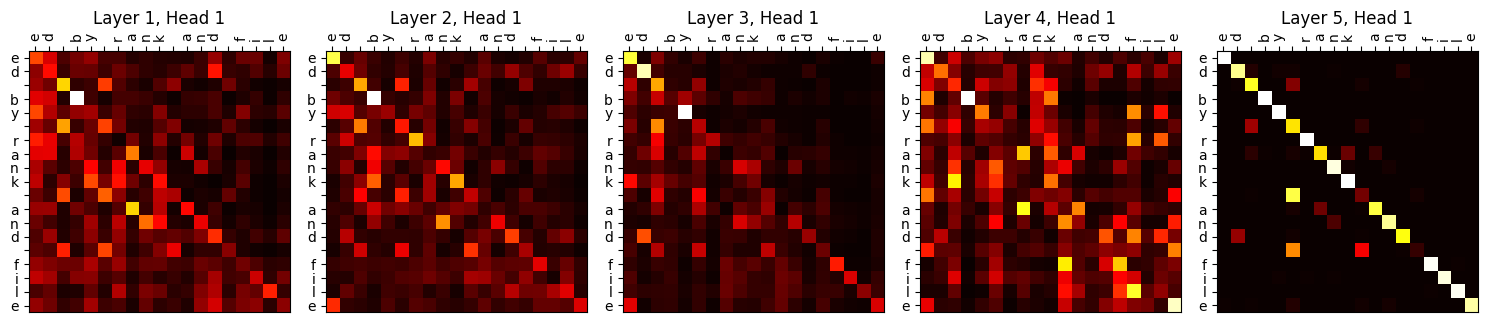

In [16]:
print("Task 1 Attention Map...")
test_text = "ed by rank and file"
fig = plot_attention_maps_layers(model, test_text, save_path="attention_maps.png")

Layer 1: Notices when the same character appears close together.
Layer 2: Gathers information about repeated characters and improves on what Layer 1 found.
Layer 3: Combines information from earlier layers to create more advanced patterns.
Layer 4: Starts changing the attention patterns to help make the final decision.
Layer 5: Fine-tunes the focus on repeated characters that matter most for the task, leading to the final answer.










#### Deliverable 5.3) Train a multi-head model on one of the tasks.
Achieve an eval accuracy of at least 80%, and plot the attention maps below on the string `"ed by rank and file"`.

Hypothesize on how each head contributes to the classification.

ANSWER HERE

In [17]:
from torch.nn import NLLLoss, CrossEntropyLoss
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.functional import log_softmax
from torch import no_grad
from tqdm import tqdm



model = Transformer(
    vocab_size=27,
    max_seq_len=20,
    d_model=64,
    d_internal=128,
    d_ff=256,
    num_classes=3,
    num_layers=1,
    num_heads=4
)

loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)
num_epochs = 10

for ep in range(num_epochs):
    model.train()
    train_loss, train_preds, train_targets = 0.0, [], []
    for x, y in zip(train_ids, train_task1):
        x = x[:20]
        y = y[:20]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        optimizer.zero_grad()
        output, maps = model(x)
        output = output.view(-1, 3)
        y = y.view(-1)

        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = output.argmax(dim=1)
        train_preds.extend(preds.tolist())
        train_targets.extend(y.tolist())


    acc = accuracy_score(train_targets, train_preds)
    f1 = f1_score(train_targets, train_preds, average='macro')
    print(f"Epoch {ep+1}: Train Loss = {train_loss/len(train_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")

    model.eval()
    eval_loss, eval_preds, eval_targets = 0.0, [], []
    with no_grad():
        for x, y in zip(dev_ids, dev_task1):
            x = x[:20]
            y = y[:20]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)

            output, maps = model(x)
            output = output.view(-1, 3)
            y = y.view(-1)



            loss = loss_fn(output, y)
            eval_loss += loss.item()
            preds = output.argmax(dim=1)
            eval_preds.extend(preds.tolist())
            eval_targets.extend(y.tolist())

    acc = accuracy_score(eval_targets, eval_preds)
    f1 = f1_score(eval_targets, eval_preds, average='macro')



    print(f"Epoch {ep+1}: Eval Loss = {eval_loss/len(dev_ids):.4f}, Acc = {acc:.4f}, F1 = {f1:.4f}")


Epoch 1: Train Loss = 0.4792, Acc = 0.7929, F1 = 0.7304
Epoch 1: Eval Loss = 0.1813, Acc = 0.9368, F1 = 0.9148
Epoch 2: Train Loss = 0.0997, Acc = 0.9654, F1 = 0.9519
Epoch 2: Eval Loss = 0.0530, Acc = 0.9815, F1 = 0.9748
Epoch 3: Train Loss = 0.0438, Acc = 0.9852, F1 = 0.9788
Epoch 3: Eval Loss = 0.0362, Acc = 0.9868, F1 = 0.9813
Epoch 4: Train Loss = 0.0286, Acc = 0.9903, F1 = 0.9859
Epoch 4: Eval Loss = 0.0317, Acc = 0.9886, F1 = 0.9839
Epoch 5: Train Loss = 0.0214, Acc = 0.9929, F1 = 0.9897
Epoch 5: Eval Loss = 0.0267, Acc = 0.9897, F1 = 0.9847
Epoch 6: Train Loss = 0.0162, Acc = 0.9948, F1 = 0.9924
Epoch 6: Eval Loss = 0.0232, Acc = 0.9920, F1 = 0.9876
Epoch 7: Train Loss = 0.0133, Acc = 0.9957, F1 = 0.9937
Epoch 7: Eval Loss = 0.0203, Acc = 0.9932, F1 = 0.9892
Epoch 8: Train Loss = 0.0117, Acc = 0.9962, F1 = 0.9942
Epoch 8: Eval Loss = 0.0158, Acc = 0.9939, F1 = 0.9904
Epoch 9: Train Loss = 0.0098, Acc = 0.9969, F1 = 0.9955
Epoch 9: Eval Loss = 0.0088, Acc = 0.9968, F1 = 0.9956
E

Task 1 Attention Map...
Maps type: <class 'list'>
Maps list length: 1
First map shape: torch.Size([4, 19, 19])
Figure saved to attention_maps.png


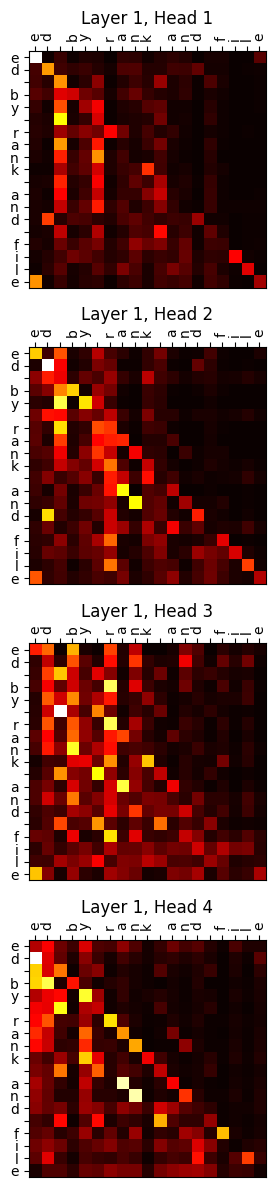

In [18]:
print("Task 1 Attention Map...")
test_text = "ed by rank and file"
fig = plot_attention_maps(model, test_text, save_path="attention_maps.png")



```
The first head notices when a character appears for the very first time.
The second head pays attention to when characters show up again, especially the second time they appear.
The third head looks at the big picture or specific patterns of characters.
The fourth head combines information about where characters are positioned and how often they appear.

By splitting the work this way, the system can handle the complex task of counting characters more effectively. Each head specializes in one aspect of the job - like spotting new characters or tracking repeats. Then all this information gets combined to make the final decision.
```



#### Acknowledgement

This homework was adapted from CS388, taught by Greg Durrett at University of Texas Austin, and CS685, taught by Mohit Iyyer, then at University of Massachusetts Amherst.

The visualizations take inspiration from a twitter post by Mark Riedl of Georgia Tech.